In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.random.uniform(x0_min, x0_max, size = n)
    x1s = np.random.uniform(x1_min, x1_max, size = n)
    return np.stack([x0s, x1s], axis = 1)

def get_X_2d_interval(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.linspace(x0_min, x0_max, num = n)
    x1s = np.linspace(x1_min, x1_max, num = n)
    x0, x1 = np.meshgrid(x0s, x1s)
    return np.stack([x0.flatten(), x1.flatten()], axis = 1)

def gen_sine(n, drifted = False):
    x0_min, x0_max = -3.14, 3.14
    x1_min, x1_max = -1, 1
    X = get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max)
    y = np.array((X[:, 1] > np.sin(X[:, 0])) != drifted).astype(int)
    return X, y

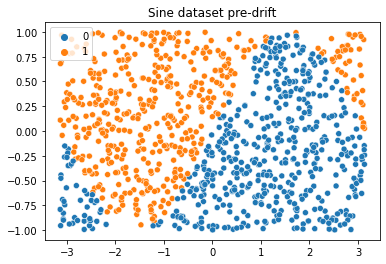

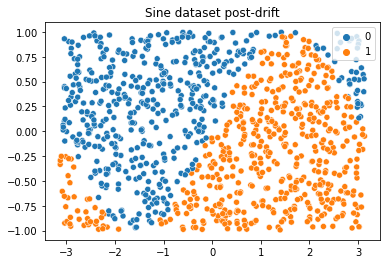

In [3]:
n_samples = 1000

X_pre, y_pre = gen_sine(n_samples)
X_post, y_post = gen_sine(n_samples, drifted = True)

plt.title('Sine dataset pre-drift')
sns.scatterplot(x = X_pre[:, 0], y = X_pre[:, 1], hue = y_pre)
plt.show()

plt.title('Sine dataset post-drift')
sns.scatterplot(x = X_post[:, 0], y = X_post[:, 1], hue = y_post)
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size = 0.25)

In [5]:
model = keras.Sequential(
    [
        keras.Input(shape = (2,)),
        keras.layers.Dense(4, activation="sigmoid"),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

2021-12-20 15:26:38.299409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 15:26:38.355651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-20 15:26:38.365469: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-20 15:26:38.368367: I tensorflow/core/platform/cpu_f

In [6]:
hist = model.fit(
    x = X_train,
    y = y_train,
    epochs = 200,
    validation_split = 0.1,
    verbose = 0
)

In [7]:
hist_df = pd.DataFrame.from_dict(hist.history)

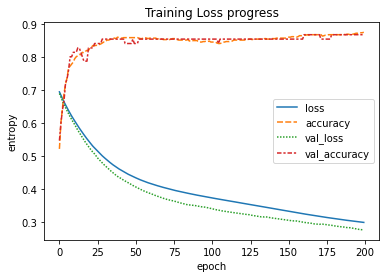

In [8]:
plt.title('Training Loss progress')

sns.lineplot(data = hist_df)
plt.xlabel('epoch')
plt.ylabel('entropy')
plt.show()

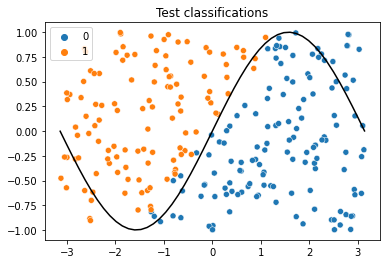

In [9]:
y_pre_pred = (model.predict(X_test)[:, 0] > 0.5).astype(int)

plt.title('Test classifications')

# training data 
#sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue = y_train, alpha = 0.1)

# pred data 
sns.scatterplot(x = X_test[:, 0], y = X_test[:, 1], hue = (y_pre_pred > 0.5).astype(int))

# underlying function
sns.lineplot(x = np.linspace(-3.14, 3.14), y = np.sin(np.linspace(-3.14, 3.14)), color = 'k')

plt.show()

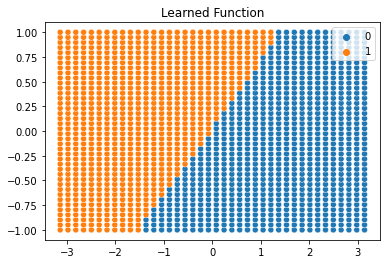

In [10]:
X_f = get_X_2d_interval(40, -3.14, 3.14, -1, 1)
y_pred_f = (model.predict(X_f)[:, 0] > 0.5).astype(int)

plt.title('Learned Function')

# pred data 
sns.scatterplot(x = X_f[:, 0], y = X_f[:, 1], hue = y_pred_f)

plt.show()

In [11]:
# pre-drift error rate
test_error_rate = 1 - accuracy_score(y_pre_pred, y_test)
print("Error rate pre-drift: %.1f%%" % (test_error_rate * 100))

Error rate pre-drift: 11.2%


Get the error rate over time to implement the Drift Detection Method

In [12]:
# get error rate over time with data that models the same concept as the test/train data
n_prod_pre = 1000
n_prod_post = 500
X_prod_pre, y_prod_pre = gen_sine(n_prod_pre, drifted = False)
X_prod_post, y_prod_post = gen_sine(n_prod_post, drifted = True)

X_prod = np.vstack([X_prod_pre, X_prod_post])
y_prod = np.concatenate([y_prod_pre, y_prod_post])

In [72]:
err_rate_seq = []
err_sd_seq = []
#t_seq = []
t_min_seq = []

err_rate_min = np.inf
err_sd_min = np.inf

n_errors = n_examples_seen = 0
t_min = 0

# detection thresholds
warning_deviations = 2
drift_deviations = 3

warmup_time = 100 # needed to approximate normal distribution

# go through examples one-at-a-time
for t, (X, y) in enumerate(zip(X_prod, y_prod)):
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(model.predict(X)[0] > 0.5)
    
    # increment counters
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    
    # calculate metrics: standard deviation and error rate
    err_rate = n_errors / n_examples_seen
    err_sd = np.sqrt( err_rate * (1 - err_rate) / n_examples_seen )
    
    # update min registers
    if err_rate + err_sd < err_rate_min + err_sd_min and t > warmup_time:
        err_rate_min, err_sd_min = err_rate, err_sd
        t_min = t
    
    err_rate_seq.append(err_rate)
    err_sd_seq.append(err_sd)
    
    #t_seq.append(t)
    t_min_seq.append(t_min)

In [73]:
err_rate_min_seq = np.array([err_rate_seq[i] for i in t_min_seq])
err_sd_min_seq = np.array([err_sd_seq[i] for i in t_min_seq])

err_rate_seq = np.array(err_rate_seq)
err_sd_seq = np.array(err_sd_seq)

In [81]:
# ex post facto calculate the warning and drift thresholds for now
warning_seq = err_rate_seq + err_sd_seq >= err_rate_min_seq + warning_deviations * err_sd_min_seq
drift_seq = err_rate_seq + err_sd_seq >= err_rate_min_seq + drift_deviations * err_sd_min_seq

warning_seq[:warmup_time + 1] = False #suppress false alarms
drift_seq[:warmup_time + 1] = False #suppress false alarms

alarm_seq = warning_seq.astype(int) + drift_seq.astype(int)

In [84]:
t_warning = np.argmax(warning_seq)
t_drift = np.argmax(drift_seq)

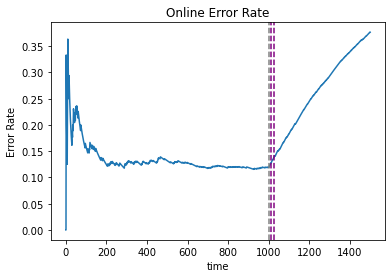

In [93]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq)
#plt.axhline(test_error_rate, color = 'k', linestyle = '--')
plt.axvline(n_prod_pre, color = 'gray', linestyle = '--')
plt.axvline(t_warning, color = 'purple', linestyle = '--')
plt.axvline(t_drift, color = 'purple', linestyle = '--')
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

Above, the horizontal line is the test set error rate (pre-prod) and the vertial line is when the sudden drift happened in the prod data. We can see the error rate increasing dramatically at this point.

This image from Gama et al (2004) shows the same trend.
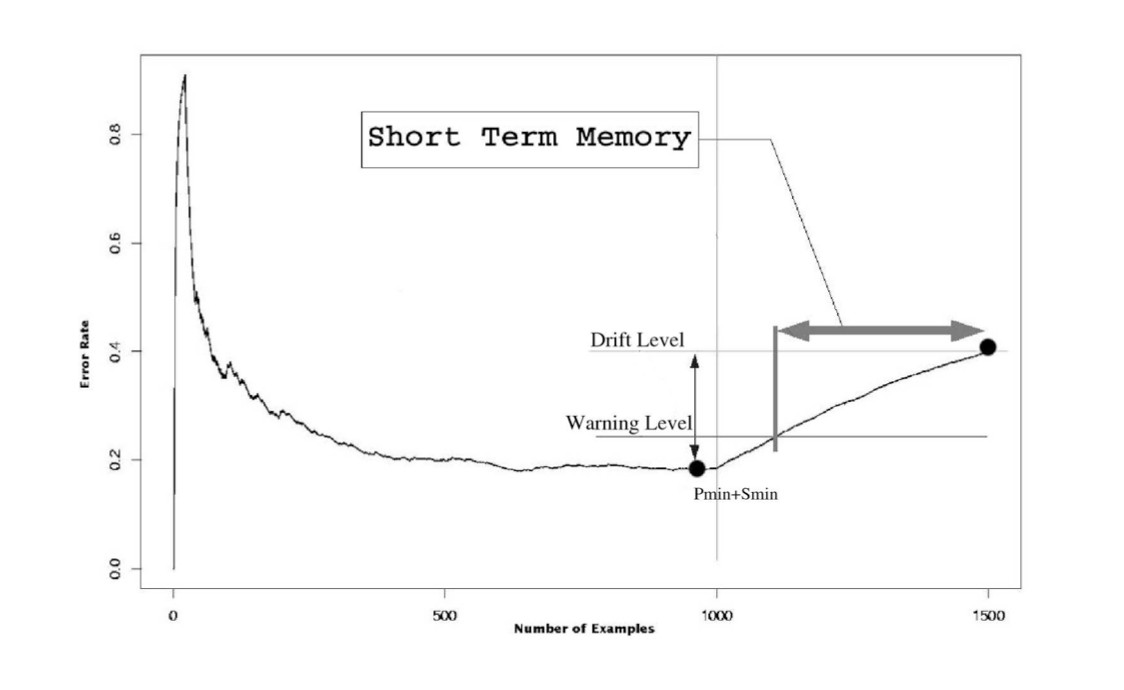

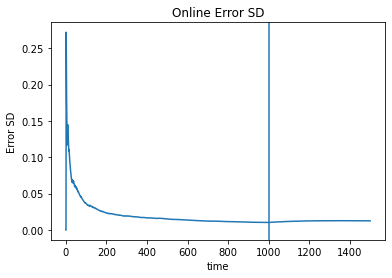

In [28]:
plt.title("Online Error SD")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_sd_seq)
plt.axvline(n_prod_pre)
plt.ylabel('Error SD')
plt.xlabel('time')
plt.show()

In [ ]:
-